# Generative Adversarial Networks

## MLP backbone

In [1]:
# Import statements
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [ ]:
transform = transforms.ToTensor()
train_data = MNIST(root='data', train=True, download=True, transform=transform)

In [3]:
batch_size = 64
num_workers = 0
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)

In [4]:
images, labels = iter(train_loader).next()
images = images.numpy()

In [5]:
print('Maximum intensity value:', np.max(images[0].squeeze()))
print('Minimum intensity value:', np.min(images[0].squeeze()))

Maximum intensity value: 1.0
Minimum intensity value: 0.0


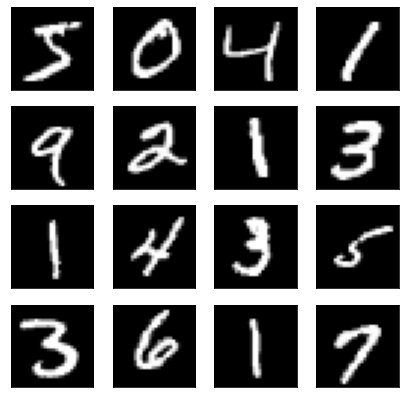

In [6]:
fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
for ax, img in zip(axes.flatten(), images[:16]):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.reshape((28,28)), cmap='gray')

In [7]:
class Discriminator(nn.Module):

    def __init__(self, input_size=784, hidden=(128, 64, 32), output_size=1):
        super(Discriminator, self).__init__()

        # Hidden layers
        self.fc1 = nn.Linear(input_size, hidden[0])
        self.fc2 = nn.Linear(hidden[0], hidden[1])
        self.fc3 = nn.Linear(hidden[1], hidden[2])

        # Output layer
        self.fc4 = nn.Linear(hidden[2], output_size)

        # Dropout layer
        self.dropout = nn.Dropout(.3)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.leaky_relu(self.fc1(x), .2) 
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), .2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), .1)
        x = self.dropout(x)
        out = self.fc4(x)
        return out
  

In [8]:
class Generator(nn.Module):

    def __init__(self, input_size=100, hidden=(32, 64, 128), output_size=784):
        super(Generator, self).__init__()

        # Hidden layers
        self.fc1 = nn.Linear(input_size, hidden[0])
        self.fc2 = nn.Linear(hidden[0], hidden[1])
        self.fc3 = nn.Linear(hidden[1], hidden[2])

        # Output layer
        self.fc4 = nn.Linear(hidden[2], output_size)

        # Dropout layer
        self.dropout = nn.Dropout(.3)

        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), .2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), .2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), .2)
        x = self.dropout(x)
        out = torch.tanh(self.fc4(x))
        return out

In [9]:
dis = Discriminator(784, (128, 64, 32),  1)
gen = Generator(100, (32, 64, 128), 784)

In [10]:
def real_loss(out, smooth=False, train_on_gpu=False):
    """
    Calculate Binary Cross Entropy Loss from logit

    Label smoothing can be done to have a numerically stable loss function
    """
    batch_size = out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)

    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(out.squeeze(), labels)
    return loss

def fake_loss(out, train_on_gpu=False):
    batch_size = out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(out.squeeze(), labels)
    return loss

In [11]:
# Optimizers
lr = 0.002
d_opt = optim.Adam(dis.parameters(), lr)
g_opt = optim.Adam(gen.parameters(), lr)

In [12]:
def train(train_loader, dis, gen, d_opt, g_opt, num_epochs=200, smooth=False):
    train_on_gpu = torch.cuda.is_available()
    if train_on_gpu:
        print('Training on GPU...')
        dis.cuda()
        gen.cuda()
    gen_out = []
    losses = []

    sample_size = 4
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, 100))
    fixed_z = torch.from_numpy(fixed_z).float()

    dis.train()
    gen.train()

    for epoch in range(num_epochs):
        
        for real_images, labels in train_loader: 
            batch_size = real_images.size(0)
            
            real_images = real_images*2 - 1  # Very important

            if train_on_gpu:
                real_images = real_images.cuda()
          
            # Train discriminator
            d_opt.zero_grad()

            d_real = dis(real_images)
            d_real_loss = real_loss(d_real, smooth=True, train_on_gpu=train_on_gpu)

            with torch.no_grad():
                z = np.random.uniform(-1, 1, size=(batch_size, 100))
                z = torch.from_numpy(z).float()
                if  train_on_gpu:
                    z = z.cuda()
                fake_images = gen(z)
            d_fake = dis(fake_images)
            d_fake_loss = fake_loss(d_fake, train_on_gpu=train_on_gpu)

            d_loss = d_real_loss + d_fake_loss

            d_loss.backward()
            d_opt.step()
            
            # Train generator
            g_opt.zero_grad()

            z = np.random.uniform(-1, 1, size=(batch_size, 100))
            z = torch.from_numpy(z).float()
            if  train_on_gpu:
                z = z.cuda()           
            fake_images = gen(z)

            d_fake = dis(fake_images)
            g_loss = real_loss(d_fake, train_on_gpu=train_on_gpu) 
          
            g_loss.backward()
            g_opt.step()

        if epoch % 20 == 0:
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(epoch+1, num_epochs, d_loss.item(), g_loss.item()))
        
            gen.eval()
            if  train_on_gpu:
                fixed_z = fixed_z.cuda()
            samples = gen(fixed_z)
            gen.train()

            _, axes = plt.subplots(figsize=(7,7), nrows=1, ncols=4, sharey=True, sharex=True)
            for ax, img in zip(axes.flatten(), samples):
                img = img.detach().cpu()
                ax.xaxis.set_visible(False)
                ax.yaxis.set_visible(False)
                im = ax.imshow(img.reshape((28,28)), cmap='gray')
            plt.show()  


        losses.append((d_loss.item(), g_loss.item()))
    return np.array(losses)

Training on GPU...
Epoch [    1/  100] | d_loss: 1.2435 | g_loss: 1.5463


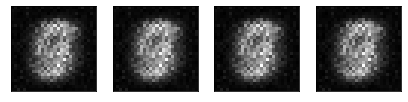

Epoch [   21/  100] | d_loss: 1.2475 | g_loss: 1.1499


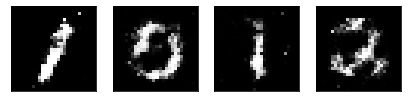

Epoch [   41/  100] | d_loss: 1.2314 | g_loss: 1.1386


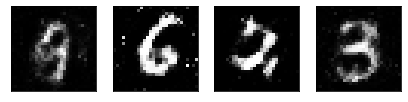

Epoch [   61/  100] | d_loss: 1.0264 | g_loss: 1.8718


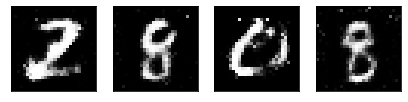

Epoch [   81/  100] | d_loss: 1.1369 | g_loss: 1.1231


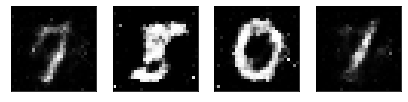

In [13]:
EPOCHS = 100
losses = train(train_loader, dis, gen, d_opt, g_opt, num_epochs=EPOCHS, smooth=True)

In [14]:
def plot_losses(losses):
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()
    plt.show()

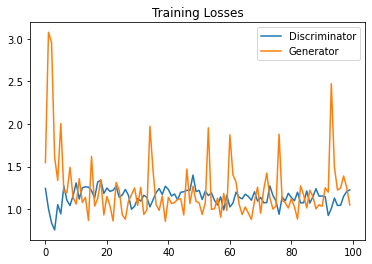

In [15]:
plot_losses(losses)

In [25]:
def view_samples(gen, reshape=False):
    gen.to('cpu')
    sample_size = 16
    z = np.random.uniform(-1, 1, size=(sample_size, 100))
    z = torch.from_numpy(z).float()
    gen.eval()
    generated_images = gen(z)

    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), generated_images):
        img = img.detach().squeeze()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        if reshape:
            img = img.reshape((28,28))
        im = ax.imshow(img, cmap='gray')

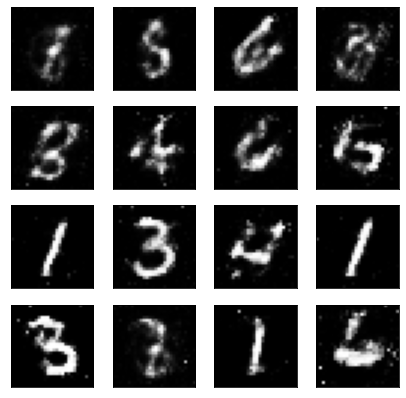

In [17]:
view_samples(gen, reshape=True)

## Deep Convolutional GAN

In [18]:
class DiscriminatorDC(nn.Module):

    def __init__(self, input_size=28, depth=32, output_size=1):
        super(DiscriminatorDC, self).__init__()

        # Convolutional layers
        self.depth = depth
        self.conv1 = nn.Conv2d(1, depth, 4, stride=2, padding=1, bias=False)
        self.conv2 = nn.Conv2d(depth, depth*2, 4, stride=2, padding=1, bias=False)
        self.conv3 = nn.Conv2d(depth*2, depth*4, 3, stride=2, padding=1, bias=False)

        # Output layer
        self.fc = nn.Linear(depth*4*4*4, output_size)

        # Batch normalization
        self.batch_norm2 = nn.BatchNorm2d(depth*2)
        self.batch_norm3 = nn.BatchNorm2d(depth*4)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), .2) 
        x = self.conv2(x)
        x = F.leaky_relu(self.batch_norm2(x), .2)
        x = self.conv3(x)
        x = F.leaky_relu(self.batch_norm3(x), .2)
        x = x.view(-1, self.depth*4*4*4)
        out = self.fc(x)
        return out
  

In [19]:
class GeneratorDC(nn.Module):

    def __init__(self, input_size=100, depth=32, output_size=28):
        super(GeneratorDC, self).__init__()

        # Fully-connected layer
        self.fc = nn.Linear(input_size, depth*4*4*4)

        # Transposed Convolutional layers
        self.depth = depth
        self.tconv1 = nn.ConvTranspose2d(depth*4, depth*2, 3, stride=2, padding=1, bias=False)
        self.tconv2 = nn.ConvTranspose2d(depth*2, depth, 4, stride=2, padding=1, bias=False)
        self.tconv3 = nn.ConvTranspose2d(depth, 1, 4, stride=2, padding=1, bias=False)

        # Batch normalization
        self.batch_norm1 = nn.BatchNorm2d(depth*2)
        self.batch_norm2 = nn.BatchNorm2d(depth)

        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.depth*4, 4, 4)
        x = self.tconv1(x)
        x = F.relu(self.batch_norm1(x))
        x = self.tconv2(x)
        x = F.relu(self.batch_norm2(x))
        x = self.tconv3(x)
        out = torch.tanh(x)
        return out

In [20]:
dis = DiscriminatorDC(28, 32,  1)
gen = GeneratorDC(100, 32, 28)

In [21]:
# Optimizers
lr = 0.0002
d_opt = optim.Adam(dis.parameters(), lr, [.5, .999])
g_opt = optim.Adam(gen.parameters(), lr, [.5, .999])

Training on GPU...
Epoch [    1/  100] | d_loss: 0.5404 | g_loss: 2.6366


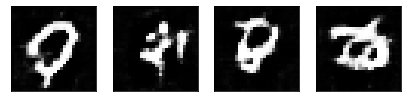

Epoch [   21/  100] | d_loss: 0.4466 | g_loss: 4.0802


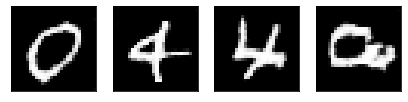

Epoch [   41/  100] | d_loss: 0.3671 | g_loss: 5.0038


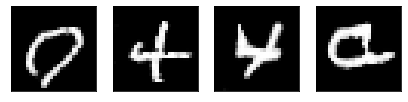

Epoch [   61/  100] | d_loss: 0.3640 | g_loss: 7.6546


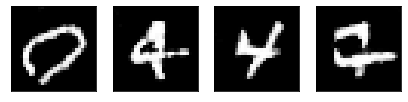

Epoch [   81/  100] | d_loss: 0.3561 | g_loss: 3.9981


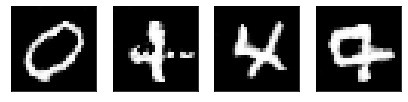

In [22]:
EPOCHS = 100
losses = train(train_loader, dis, gen, d_opt, g_opt, num_epochs=EPOCHS)

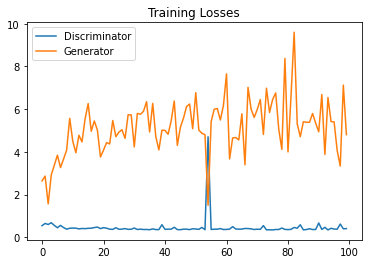

In [23]:
plot_losses(losses)

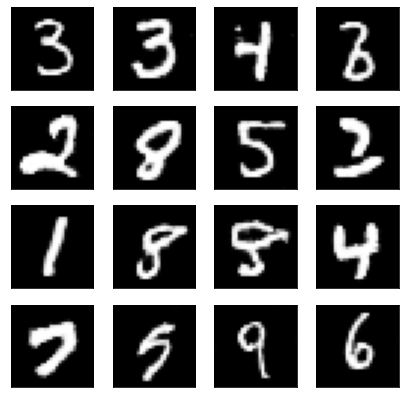

In [26]:
view_samples(gen)